In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math
import random

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

<h1>More Regression</h1>

We can now generate linear regression models that can predict a Y value when we supply an X value - cool!

What about accuracy. How much can we trust these models to make accurate predictions?

For regression we have two primary metrics of accuracy that we look at first - RMSE and R2 (R squared). We can look at each individually, they are both pretty simple and easy to calculate. 

We'll load some data where there is more error than the NBA/NFL example from last time. 

In [4]:
#Load Data
df = pd.read_csv("WalMartSales.csv")
df.head()

,﻿Store,FuelPrice,StoreSize,WeekAvgTemp,Unemployment,Sales,SalesPerSqFt
0,1.0,3.10,151315.0,47.0,7.43,22516.0,0.15
1,1.0,3.14,151315.0,42.0,7.43,22805.0,0.15
2,1.0,3.18,151315.0,51.0,7.43,22082.0,0.15
3,1.0,3.24,151315.0,55.0,7.43,19580.0,0.13
4,1.0,3.31,151315.0,54.0,7.43,21299.0,0.14


We can look at how accurately can we predict store sales at a WalMart, if we know the size of the store. 

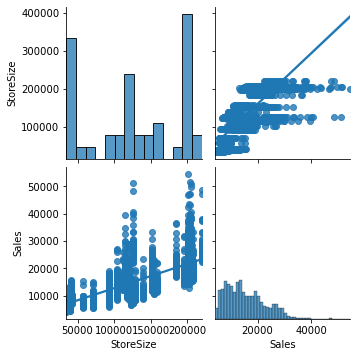

In [5]:
#We can take a preview
x1 = "StoreSize"
y1 = "Sales"
d = df[["StoreSize", "Sales"]]
sns.pairplot(d, kind="reg")

It appears that there is a relationship. Regression time...

In [6]:
#Do regression
inter, slope = thinkstats2.LeastSquares(d[x1],d[y1])
res = thinkstats2.Residuals(d[x1], d[y1], inter, slope)
regLine = thinkstats2.FitLine(d[x1], inter, slope)
print("Y intercept:", inter)
print("Slope:", slope)

Y intercept: 3894.1995234044243
Slope: 0.08860428376940385


<AxesSubplot:xlabel='StoreSize', ylabel='Sales'>

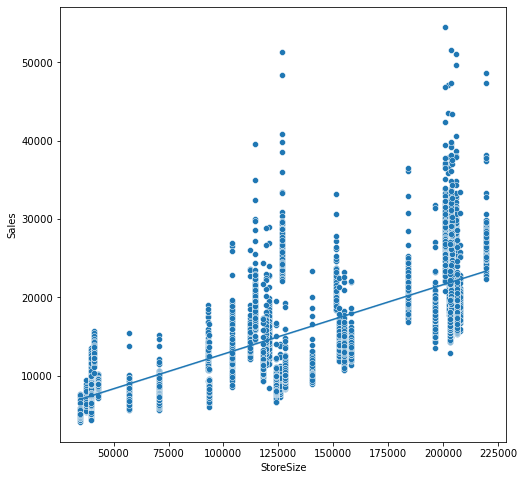

In [7]:
#Plot with regression line
sns.scatterplot(x=d[x1], y=d[y1])
sns.lineplot(x=regLine[0], y=regLine[1])

<AxesSubplot:xlabel='StoreSize', ylabel='Sales'>

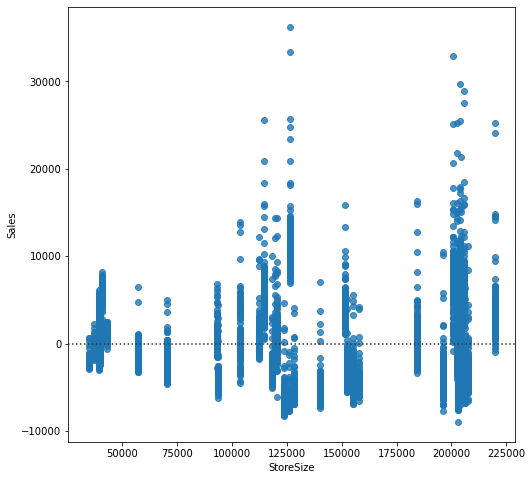

In [8]:
#Plot Residuals
sns.residplot(x=d[x1], y=d[y1])

Ok. We have a regression, it doesn't really look like it is the best one. 

We need to quantify the accuracy. First - RMSE. 

The RMSE is the same concept of every other time we've looked at it - take the residuals, square them, sum those up, take the square root. We can build a pretty simple calculator to find RMSE, or we can use one of the library functions. 

In [21]:
#Calculate RMSE from residuals
def rmseFromResiduals(residuals):
    SSE = 0
    for i in range(len(residuals)):
        SSE += (residuals[i]**2)
    MSE = SSE/len(residuals)
    return math.sqrt(MSE)

In [22]:
rmseFromResiduals(res)

4681.269671003714

What if we are using one of the library functions? We'll use statsmodels here. The RMSE stuff is the same for sklearn. 

In [30]:
#Fit the model and get the summary of results. 
import statsmodels.api as sm
x2 = sm.add_constant(d[x1])
est = sm.OLS(d[y1], x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     9180.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:32:14   Log-Likelihood:                -63515.
No. Observations:                6435   AIC:                         1.270e+05
Df Residuals:                    6433   BIC:                         1.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3894.1995    133.881     29.087      0.0

Now to generate an RMSE, we need to get the actual predictions. 

In [32]:
#Fit the model which we have already done
#Now generate predictions for our data
ypred = est2.predict(x2)

At this point, we have the predictions, we also have the real values, we can use any RMSE caclulator to get the answer. 

In [33]:
#Calculate the RMSE, here using the statsmodel function. 
from statsmodels.tools.eval_measures import rmse
rmse(d[y1], ypred)


4681.269671003718

In [34]:
#Sklearn like we did before. 
mean_squared_error(d[y1], ypred, squared=False)

4681.269671003718

In [36]:
#Or define a function to use what we made.
def rmseFromPredictions(real, predicted):
    residuals = real-predicted
    return rmseFromResiduals(residuals)

In [37]:
rmseFromPredictions(d[y1], ypred)

4681.269671003714

RMSE is a major metric for the accuracy of our model, it tells us how close our predictions are. 

One other metric that is important in evaluating our model is called R2 or R2 or the Coefficient of Determination. The definition of R2 is "the percentage of variation in the dependent or predicted variable (y) that can be explained by variation in the independent or explanatory variable (x)" - or roughly how much of the total picture our model captures. R2 values go up from 0 to 1 (you can get other values, but that's an indication the model is pretty useless. Only 0 to 1 matters in practice), and they are expressable as a percent. The R2 value is also called the "goodness of fit". 

For an example of what R2 means, think about a car stopping via its brakes. The R2 of brakes vs stopping distance might be .8 - or 80% of how long it takes you to stop is due to how hard you press the brake pedal. The other 30% is other stuff - tire grip on the road, tail/head wind, ABS modulation, etc... For the walmart one we are doing here, the R2 will tell us what percentage of sales are attributed to store size, and what percentage is due to other stuff - location, prices, products, staff, coupons, etc...

We can calculate this pretty simply - it is the ratio of the variance of the residuals to the varaiance of the y values in total. 

In [65]:
def rSquared(yvals, residuals):
    return (1-(thinkstats2.Var(residuals)/thinkstats2.Var(yvals)))

It can also be expressed like this, this is the definition you get from Wikipedia. 1 - SumSquaresResiduals/TotalSumSquares

In [66]:
def rSquared_2(yvals, residuals):
    RSS = 0
    TSS = 0
    ybar = yvals.mean()
    for i in range(len(residuals)):
        RSS += (residuals[i]**2)
        TSS += ((yvals[i]-ybar)**2)
    r2 = 1-(RSS/TSS)
    return r2

In [67]:
rSquared_2(d[y1], res)

0.587959568854819

As a fun note, this is equal to the Pearson correlation squared. 

In [68]:
1-thinkstats2.Corr(d[y1], res)**2

0.5879595688548194

Hopefully those two match what the statsmodels has above!!!!
<br><br><br>

These two values - RMSE and R2 - are the two primary (mostly - more on this later, along with R2 limitations) metrics that we can use to evaluate a model's accuracy and its predictive value. If we have a high R2 and a (comparatively) low RMSE, we are probably making reliable predictions. 

Now, load some other data and give it a try... 

Do a linear regression and calculate R2 and the RMSE for this data. Use head size to predict brain weight. It is relatively easy to measure the size of someone's dome, but pretty hard to weigh their brain. We want to see how accurately we can predict one from the other. Does the model look like we can trust it to make good predictions?  

In [69]:
df2 = pd.read_csv("brain.csv")
df2.head()

,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


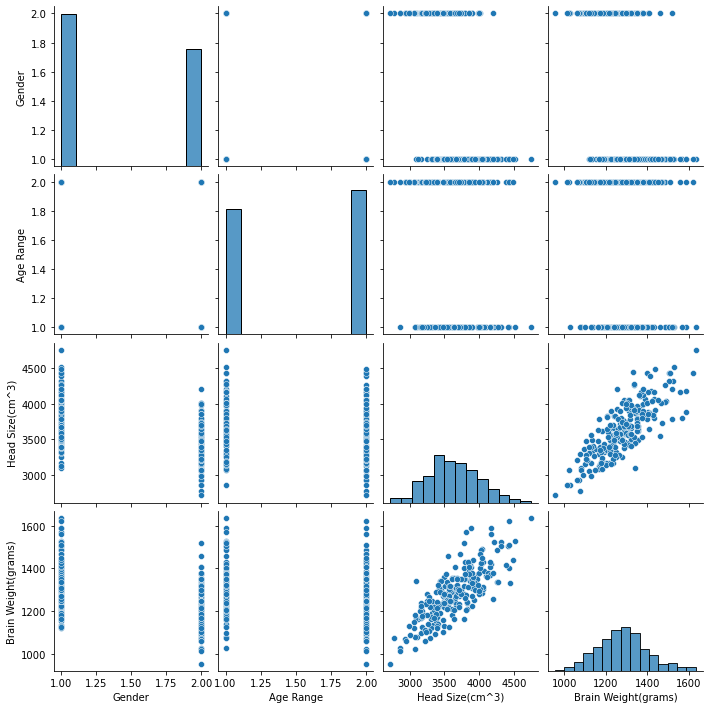

In [70]:
sns.pairplot(df2)

In [ ]:
#Do a regression. 

In [ ]:
#Plot the result, and the residuals

In [ ]:
#Calculate RMSE

In [ ]:
#Calculate R2

In [ ]:
#Use the models to do some predicting.